<h1 align=center><font size = 5>Segmenting and Clustering Neighborhoods in Toronto</font></h1>
Introduction:
In this project I explore, segment, and cluster the neighborhoods in the city of Toronto. The neighborhood data though is not readily available on the internet.
For the Toronto neighborhood data, a Wikipedia page: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M exists that has all the information we need to explore and cluster the neighborhoods in Toronto. We will have to scrape the Wikipedia page and wrangle the data, clean it, and then read it into a pandas dataframe so that it is in a structured format.

Once the data is in a structured format, we can start the analysis to explore and cluster the neighborhoods in the city of Toronto.

We build the code to scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, in order to obtain the data that is in the table of postal codes and to transform the data into a pandas dataframe.

The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood. We only process the cells that have an assigned borough. We ignore cells with a borough that is Not assigned. More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma. If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough. So for the 9th cell in the table on the Wikipedia page, the value of the Borough and the Neighborhood columns will be Queen's Park.

There are different website scraping libraries and packages in Python. One of the most common packages is BeautifulSoup and we will use it in this project. Package's main documentation page: http://beautiful-soup-4.readthedocs.io/en/latest/

Before we get the data and start exploring it, let's download all the dependencies that we will need.




In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
!conda install -c anaconda beautifulsoup4 --yes
from bs4 import BeautifulSoup
!conda install -c anaconda lxml --yes
import lxml
print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0



geopy-1.22.0         | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: 

<h1>Download, scrape and wrangle</h1>

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

text_result = requests.get(url).text #get the entire html of the article as a str
html_parsed_result = BeautifulSoup(text_result, 'html.parser') #transform the text to html

neightborhood_info_table = html_parsed_result.find('table', class_ = 'wikitable')
neightborhood_rows = neightborhood_info_table.find_all('tr')

# extract the info ('Postcode', 'Borough', 'Neighbourhood') from the table
neightborhood_info = []
for row in neightborhood_rows:
    info = row.text.split('\n')[1:-1] # remove empty str (first and last items)
    neightborhood_info.append(info)
#create a Neighborhoods dataframe
neightborhood_info[0][-1] = 'Neighborhood' # change to american spelling
neighborhood_df = pd.DataFrame(neightborhood_info[1:], columns=neightborhood_info[0])
neighborhood_df.rename(columns={'Postal Code':'Postcode'}, inplace=True)
neighborhood_df.head(10)

,Postcode,,Borough,,Neighborhood
0,M1A,,Not assigned,,Not assigned
1,M2A,,Not assigned,,Not assigned
2,M3A,,North York,,Parkwoods
3,M4A,,North York,,Victoria Village
4,M5A,,Downtown Toronto,,"Regent Park, Harbourfront"
5,M6A,,North York,,"Lawrence Manor, Lawrence Heights"
6,M7A,,Downtown Toronto,,"Queen's Park, Ontario Provincial Government"
7,M8A,,Not assigned,,Not assigned
8,M9A,,Etobicoke,,"Islington Avenue, Humber Valley Village"
9,M1B,,Scarborough,,"Malvern, Rouge"


In [3]:
not_assigned_boroughs = neighborhood_df.index[neighborhood_df['Borough'] == 'Not assigned']
not_assigned_neighborhoods = neighborhood_df.index[neighborhood_df['Neighborhood'] == 'Not assigned']
not_assigned_neighborhoods_and_borough = not_assigned_boroughs & not_assigned_neighborhoods

print('The DataFrame shape is {}'.format(neighborhood_df.shape),'\n')
print('There are:')
print('  {} Postal codes'.format(neighborhood_df['Postcode'].unique().shape[0]))
print('  {} Boroughs'.format(neighborhood_df['Borough'].unique().shape[0] - 1)) # substract one because "not assigned" doesn't count
print('  {} Neighborhoods'.format(neighborhood_df['Neighborhood'].unique().shape[0] - 1)) # substract one because "not assigned" doesn't count
print('  {} rows with Not assigned Borough'.format(not_assigned_boroughs.shape[0]))
print('  {} rows with Not assigned Neighborhood'.format(not_assigned_neighborhoods.shape[0]))
print('  {} rows with Not assigned Neighborhood and Borough'.format(not_assigned_neighborhoods_and_borough.shape[0]),'\n')
neighborhood_df.drop(neighborhood_df.index[not_assigned_boroughs], inplace=True)
neighborhood_df.reset_index(drop=True, inplace=True)

neighborhood_df.head(10)

The DataFrame shape is (180, 5) 

There are:
  180 Postal codes
  10 Boroughs
  99 Neighborhoods
  77 rows with Not assigned Borough
  77 rows with Not assigned Neighborhood
  77 rows with Not assigned Neighborhood and Borough 



,Postcode,,Borough,,Neighborhood
0,M3A,,North York,,Parkwoods
1,M4A,,North York,,Victoria Village
2,M5A,,Downtown Toronto,,"Regent Park, Harbourfront"
3,M6A,,North York,,"Lawrence Manor, Lawrence Heights"
4,M7A,,Downtown Toronto,,"Queen's Park, Ontario Provincial Government"
5,M9A,,Etobicoke,,"Islington Avenue, Humber Valley Village"
6,M1B,,Scarborough,,"Malvern, Rouge"
7,M3B,,North York,,Don Mills
8,M4B,,East York,,"Parkview Hill, Woodbine Gardens"
9,M5B,,Downtown Toronto,,"Garden District, Ryerson"


In [4]:
not_assigned_neighborhoods = neighborhood_df.index[neighborhood_df['Neighborhood'] == 'Not assigned'] # run this again because the indexes on the dataframe where reset

for idx in not_assigned_neighborhoods:
    neighborhood_df['Neighborhood'][idx] = neighborhood_df['Borough'][idx]
    
neighborhood_df.head(10)
print('After cleaning the DataFrame, its new shape is {}'.format(neighborhood_df.shape),'\n')
print('There are:')
print('  {} Postal codes'.format(neighborhood_df['Postcode'].unique().shape[0]))
print('  {} Boroughs'.format(neighborhood_df['Borough'].unique().shape[0]))
print('  {} Neighborhoods'.format(neighborhood_df['Neighborhood'].unique().shape[0]))
neighborhood_df.head(10)

After cleaning the DataFrame, its new shape is (103, 5) 

There are:
  103 Postal codes
  10 Boroughs
  99 Neighborhoods


,Postcode,,Borough,,Neighborhood
0,M3A,,North York,,Parkwoods
1,M4A,,North York,,Victoria Village
2,M5A,,Downtown Toronto,,"Regent Park, Harbourfront"
3,M6A,,North York,,"Lawrence Manor, Lawrence Heights"
4,M7A,,Downtown Toronto,,"Queen's Park, Ontario Provincial Government"
5,M9A,,Etobicoke,,"Islington Avenue, Humber Valley Village"
6,M1B,,Scarborough,,"Malvern, Rouge"
7,M3B,,North York,,Don Mills
8,M4B,,East York,,"Parkview Hill, Woodbine Gardens"
9,M5B,,Downtown Toronto,,"Garden District, Ryerson"


In [6]:
dfll= pd.read_csv("http://cocl.us/Geospatial_data")
dfll.rename(columns={'Postal Code':'Postcode'}, inplace=True)
dfll.set_index("Postcode")
neighborhood_df.set_index("Postcode")
df2 = neighborhood_df
toronto_data=pd.merge(df2, dfll)
toronto_data.head()

,Postcode,,Borough,,Neighborhood,Latitude,Longitude
0,M3A,,North York,,Parkwoods,43.753259,-79.329656
1,M4A,,North York,,Victoria Village,43.725882,-79.315572
2,M5A,,Downtown Toronto,,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,,North York,,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,,Downtown Toronto,,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


Create a map of Toronto with neighborhoods superimposed on top.

In [7]:
map = folium.Map(location=[43.6532,-79.3832], zoom_start=11)

for location in toronto_data.itertuples(): #iterate each row of the dataframe
    label = 'PostalCode: {};  Borough: {};  Neighborhoods: {}'.format(location[1], location[2], location[3])
    label = folium.Popup(label, parse_html=True)    
    folium.CircleMarker(
        [location[-2], location[-1]],
        radius=1,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map) 
    folium.Circle(
        radius=500,
        popup=label,
        location=[location[-2], location[-1]],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc'
    ).add_to(map) 
    
map

In [24]:
from geopy.distance import great_circle

#function to get the closest postcode pair and the distance using latitude and longitude
def closest_postcode(postcode, postcodes):
    postcode = np.asarray(postcode).reshape(1,-1)
    postcodes = np.asarray(postcodes)
    distances = [great_circle(postcode, point).meters for point in postcodes]
    closest_postcode_index = np.argmin(distances)
    return [round(distances[closest_postcode_index]), closest_postcode_index]
coordinates = toronto_data[['Latitude', 'Longitude']]
distance, closest_point_index = closest_postcode(coordinates[:1], coordinates[~coordinates.index.isin([0])])
toronto_data.drop(['Distance', 'distance'], axis=1)

,Postcode,,Borough,,Neighborhood,Latitude,Longitude
0,M3A,,North York,,Parkwoods,43.753259,-79.329656
1,M4A,,North York,,Victoria Village,43.725882,-79.315572
2,M5A,,Downtown Toronto,,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,,North York,,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,,Downtown Toronto,,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
5,M9A,,Etobicoke,,"Islington Avenue, Humber Valley Village",43.667856,-79.532242
6,M1B,,Scarborough,,"Malvern, Rouge",43.806686,-79.194353
7,M3B,,North York,,Don Mills,43.745906,-79.352188
8,M4B,,East York,,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,,Downtown Toronto,,"Garden District, Ryerson",43.657162,-79.378937


In [31]:
from math import isnan
Distance=[]
for lat, lng, idx in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data.index):
    distance, closest_point_index = closest_postcode([lat,lng], coordinates[~coordinates.index.isin([idx])])
    Distance.append(distance)
d = pd.DataFrame(Distance,columns=['Distance'])

In [34]:
toronto_data = pd.merge(toronto_data, d, left_index=True, right_index=True)

In [38]:
toronto_data=toronto_data.drop(['Distance_x', 'Distance_y', 'distance'], axis=1)

In [42]:
toronto_data.head()

,Postcode,,Borough,,Neighborhood,Latitude,Longitude,Distance
0,M3A,,North York,,Parkwoods,43.753259,-79.329656,1986
1,M4A,,North York,,Victoria Village,43.725882,-79.315572,2037
2,M5A,,Downtown Toronto,,"Regent Park, Harbourfront",43.654260,-79.360636,1228
3,M6A,,North York,,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1869
4,M7A,,Downtown Toronto,,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,513


Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

<b>Define Foursquare Credentials and Version</b>

In [43]:
CLIENT_ID = '3TPUEJRW3IDQ1UDICUSK5PQ43CJQGIU3IW4TTPQDO2E5DMLD' # your Foursquare ID
CLIENT_SECRET = 'ZU023PIWBGOZDCN2ZPZE3RX4VFETSNUWDY4XCCXXBTEBGD5R' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


Let's explore the first neighborhood in our dataframe.
Get the neighborhood's name, latitude and longitude values.

In [44]:
neighborhood_latitude = toronto_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = toronto_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Parkwoods are 43.7532586, -79.3296565.


Now, let's get the top 100 venues that are in Parkwoods within a radius of 500 meters.
First, let's create the GET request URL. Name your URL url.

In [47]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=3TPUEJRW3IDQ1UDICUSK5PQ43CJQGIU3IW4TTPQDO2E5DMLD&client_secret=ZU023PIWBGOZDCN2ZPZE3RX4VFETSNUWDY4XCCXXBTEBGD5R&v=20180605&ll=43.7532586,-79.3296565&radius=1000&limit=100'

Send the GET request and examine the resutls

In [48]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ed758b73907e7001bebf40e'},
 'response': {'headerLocation': 'Parkwoods - Donalda',
  'headerFullLocation': 'Parkwoods - Donalda, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 29,
  'suggestedBounds': {'ne': {'lat': 43.762258609000014,
    'lng': -79.31721997969855},
   'sw': {'lat': 43.74425859099999, 'lng': -79.34209302030145}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b8991cbf964a520814232e3',
       'name': "Allwyn's Bakery",
       'location': {'address': '81 Underhill drive',
        'lat': 43.75984035203157,
        'lng': -79.32471879917513,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.75984035203157,
          'lng': -79.32471879917513}],
        'distance': 833,
    

From the Foursquare lab in the previous module, we know that all the information is in the items key. Before we proceed, let's borrow the get_category_type function from the Foursquare lab.

In [49]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [50]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Allwyn's Bakery,Caribbean Restaurant,43.759840,-79.324719
1,Brookbanks Park,Park,43.751976,-79.332140
2,Tim Hortons,Café,43.760668,-79.326368
3,A&W,Fast Food Restaurant,43.760643,-79.326865
4,Bruno's valu-mart,Grocery Store,43.746143,-79.324630


Number of venues returned by Foursquare are : 

In [51]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

29 venues were returned by Foursquare.


<h1 align=center>Explore Neighborhoods in Toronto</h1>
<b>Lets create a function to repeat the same process to all the neighborhoods.</b>

In [59]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [61]:
toronto_venue = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

In [69]:
print(toronto_venue.shape)
toronto_venue.head(20)

(4912, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
1,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
2,Parkwoods,43.753259,-79.329656,Tim Hortons,43.760668,-79.326368,Café
3,Parkwoods,43.753259,-79.329656,A&W,43.760643,-79.326865,Fast Food Restaurant
4,Parkwoods,43.753259,-79.329656,Bruno's valu-mart,43.746143,-79.324630,Grocery Store
5,Parkwoods,43.753259,-79.329656,Food Basics,43.760549,-79.326045,Supermarket
6,Parkwoods,43.753259,-79.329656,Shoppers Drug Mart,43.745315,-79.325800,Pharmacy
7,Parkwoods,43.753259,-79.329656,High Street Fish & Chips,43.745260,-79.324949,Fish & Chips Shop
8,Parkwoods,43.753259,-79.329656,Shoppers Drug Mart,43.760857,-79.324961,Pharmacy
9,Parkwoods,43.753259,-79.329656,Pizza Pizza,43.760231,-79.325666,Pizza Place


In [68]:
print('Total Toronto Neighborhoods:', toronto_data['Neighborhood'].shape[0])
print('Total Toronto Neighborhoods with venues:', toronto_venue['Neighborhood'].unique().shape[0])

Total Toronto Neighborhoods: 103
Total Toronto Neighborhoods with venues: 98


In [66]:
Neighborhoods_diff = np.setdiff1d(toronto_data['Neighborhood'].values,toronto_venue['Neighborhood'].unique())
Neighborhoods_diff


array(['Upper Rouge'], dtype=object)

In [70]:
toronto_data[toronto_data['Neighborhood']==Neighborhoods_diff[0]]

,Postcode,,Borough,,Neighborhood,Latitude,Longitude,Distance
95,M1X,,Scarborough,,Upper Rouge,43.836125,-79.205636,3396


<h1>Analyze Venues Data</h1>

In [71]:
venues = toronto_venue.groupby('Neighborhood').count()
venues = pd.DataFrame(list(zip(venues.index, venues['Venue'])), 
                                  columns=['Neighborhood', '# of Venues']).set_index('Neighborhood').join(toronto_data[['Neighborhood','Distance']].set_index('Neighborhood'), on='Neighborhood').reset_index()
venues['Distance'] = np.int64(venues['Distance'])
venues.loc[len(venues.index)] = ['Upper Rouge', 0, 3396] #add M5E (postcode without venues) with zero as # of venues

venues.head(10)

,Neighborhood,# of Venues,Distance
0,Agincourt,42,2959
1,"Alderwood, Long Branch",26,3414
2,"Bathurst Manor, Wilson Heights, Downsview North",30,2604
3,Bayview Village,15,1823
4,"Bedford Park, Lawrence Manor East",40,2289
5,Berczy Park,100,223
6,"Birch Cliff, Cliffside West",14,2594
7,"Brockton, Parkdale Village, Exhibition Place",100,1407
8,"Business reply mail Processing Centre, South C...",49,846
9,"CN Tower, King and Spadina, Railway Lands, Har...",15,1668


In [72]:
venues[['# of Venues']].describe()

,# of Venues
count,103.000000
mean,50.271845
std,35.036170
min,0.000000
25%,19.000000
50%,42.000000
75%,100.000000
max,100.000000


<h1>Cluster Neighborhoods</h1>

Next the Neighborhoods are clustered based on venues density. One important hyperparameter is the number of clusters and based on previous analysis a tentative value is five clusters. Next the elbow method is used to have a better sense of the optimal number.

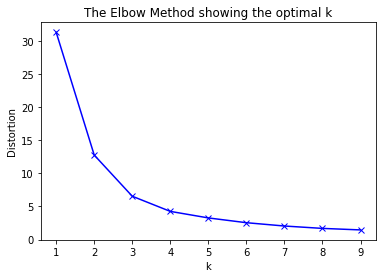

In [74]:
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.spatial.distance import cdist

distortions = []
K = range(1,10)
for k in K:
    k_means = KMeans(init = "k-means++", n_clusters = k, n_init = 12)
    k_means.fit(venues['# of Venues'].values.reshape(-1, 1))
    distortions.append(sum(np.min(cdist(venues['# of Venues'].values.reshape(-1, 1),
                                        k_means.cluster_centers_, 'euclidean'), axis=1)) / venues['# of Venues'].shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Using the elbow method, the optimal value of the number of cluster was defined as 4, which match with the value based on the histogram analysis.

In [75]:
num_clusters = 4

k_means = KMeans(init = "k-means++", n_clusters = num_clusters, n_init = 12)
k_means.fit(venues['# of Venues'].values.reshape(-1, 1))
labels = k_means.labels_

print(labels)

[3 3 3 0 3 1 0 1 3 0 0 2 3 1 1 1 3 0 1 1 1 0 2 2 3 2 2 2 2 2 1 0 3 1 2 1 3
 3 0 1 1 0 0 0 3 2 0 3 1 0 3 0 2 1 0 3 2 2 0 0 3 0 0 0 1 0 3 1 1 1 0 0 0 2
 3 0 0 1 3 3 1 1 2 1 2 1 3 2 1 1 0 0 0 0 3 3 1 0 0 3 0 0 0]


In [76]:
venues['Cluster'] = k_means.labels_
venues.head(10)

,Neighborhood,# of Venues,Distance,Cluster
0,Agincourt,42,2959,3
1,"Alderwood, Long Branch",26,3414,3
2,"Bathurst Manor, Wilson Heights, Downsview North",30,2604,3
3,Bayview Village,15,1823,0
4,"Bedford Park, Lawrence Manor East",40,2289,3
5,Berczy Park,100,223,1
6,"Birch Cliff, Cliffside West",14,2594,0
7,"Brockton, Parkdale Village, Exhibition Place",100,1407,1
8,"Business reply mail Processing Centre, South C...",49,846,3
9,"CN Tower, King and Spadina, Railway Lands, Har...",15,1668,0


In [85]:
venues.shape

(103, 4)

Check the centroids values of venues density and postcodes per cluster

In [79]:
centroids = np.int64(round(venues.groupby('Cluster').mean()['# of Venues']))
frecuency = venues.groupby('Cluster').count()['Neighborhood']

In [79]:
cluster_info = pd.DataFrame([np.arange(0,4), centroids, frecuency], index=['Cluster', 'Centroid','Neighborhood']).T
cluster_info.sort_values('Centroid', inplace=True)
cluster_info.reset_index(drop=True, inplace=True)

cluster_info

,Cluster,Centroid,Neighborhood
0,0,14,35
1,3,36,24
2,2,66,17
3,1,100,27


Here the Centroid represents mean no.of venues in a cluster
Based on the centroids of each cluster, the cluster names can be defined as:

<p>'Low Venues Density': Centroid equal to 14</p>
<p>'Medium Venues Density' with a centroid equal to 36</p>
<p>'High Venues Density' with a centroid equal to 66</p>
<p>'Very High Venues Density' with a centroid equal to 100</p>

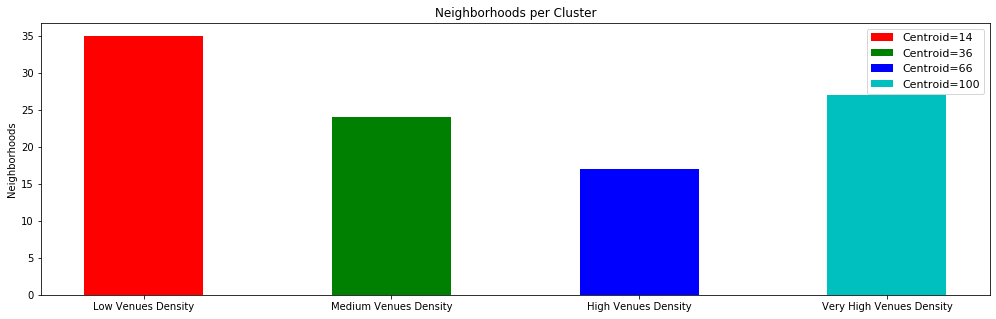

In [86]:
fig, ax = plt.subplots(figsize=(17,5))
clusters= ['Low Venues Density','Medium Venues Density','High Venues Density','Very High Venues Density']
colors = ['r','g','b','c','m']
legend = []

for id, cluster in enumerate(clusters):
    legend.append('Centroid={}'.format(cluster_info['Centroid'][id]))
    bar = ax.bar(cluster, cluster_info['Neighborhood'][id], 0.48, color=colors[id])

ax.set_ylabel('Neighborhoods')
ax.set_title('Neighborhoods per Cluster')
# ax.set_facecolor((1,1,1))
# ax.grid(True, axis='y',color='k', linestyle='-', linewidth=1)

plt.legend(legend, fontsize=11)

plt.show()

In [91]:
toronto_data = pd.concat([toronto_data[:95],toronto_data[96:],toronto_data[95:96]]) #move Upper Rouge to the last row
toronto_data['Cluster'] = k_means.labels_

colors = ['red','green','blue','cyan']
clusters_values = cluster_info['Cluster']

map = folium.Map(location=[43.6532,-79.3832], zoom_start=11)

for location in toronto_data.itertuples(): #iterate each row of the dataframe
    cluster_index = clusters_values.index[clusters_values==location[-1]][0]
    label = 'Postal Code: {};  Borough: {};  Neighborhoods: {}; {}'.format(location[1], location[2], location[3], clusters[cluster_index])
    label = folium.Popup(label, parse_html=True)    
    folium.Circle(
        radius=500,
        popup=label,
        location=[location[-4], location[-3]],
        color=None,
        fill=True,
        fill_opacity=0.4,
        fill_color=colors[cluster_index]
    ).add_to(map) 

map

In the above map we can see that :
<p>'red cluster ' - represents low venue density neighborhoods ,</p>
<p>'green cluster' - represents medium venue density neighborhoods,</p>
<p>'blue cluster' - represents high venue density neighborhoods,</p>
<p>'cyan cluster' - represents very high venue density neighborhoods.</p>
This map is clustered based on the venue density in the neighbourhoods

<b>Now we try to cluster using the same method as the lab i.e using venue categories.</b>

In [93]:
toronto_venue.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,42,42,42,42,42,42
"Alderwood, Long Branch",26,26,26,26,26,26
"Bathurst Manor, Wilson Heights, Downsview North",30,30,30,30,30,30
Bayview Village,15,15,15,15,15,15
"Bedford Park, Lawrence Manor East",40,40,40,40,40,40
Berczy Park,100,100,100,100,100,100
"Birch Cliff, Cliffside West",14,14,14,14,14,14
"Brockton, Parkdale Village, Exhibition Place",100,100,100,100,100,100
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",49,49,49,49,49,49


In [96]:
print('There are {} uniques categories.'.format(len(toronto_venue['Venue Category'].unique())))

There are 333 uniques categories.


In [97]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venue[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venue['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Zoo,Accessories Store,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Lab,College Quad,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Library,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Ski Chalet,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Sta

In [98]:
toronto_onehot.shape

(4912, 333)

In [99]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Zoo,Accessories Store,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Lab,College Quad,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Library,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Ski Chalet,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Sta

In [100]:
toronto_grouped.shape

(98, 333)

<b>Let's print each neighborhood along with the top 5 most common venues.</b>

In [101]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                  venue  freq
0    Chinese Restaurant  0.12
1         Shopping Mall  0.10
2        Sandwich Place  0.05
3  Caribbean Restaurant  0.05
4           Coffee Shop  0.05


----Alderwood, Long Branch----
               venue  freq
0     Discount Store  0.12
1  Convenience Store  0.08
2        Pizza Place  0.08
3           Pharmacy  0.08
4               Park  0.08


----Bathurst Manor, Wilson Heights, Downsview North----
                      venue  freq
0               Coffee Shop  0.07
1                      Bank  0.07
2          Sushi Restaurant  0.03
3               Men's Store  0.03
4  Mediterranean Restaurant  0.03


----Bayview Village----
                 venue  freq
0                 Bank  0.13
1        Grocery Store  0.13
2          Gas Station  0.13
3  Japanese Restaurant  0.13
4           Restaurant  0.07


----Bedford Park, Lawrence Manor East----
                venue  freq
0         Coffee Shop  0.08
1  Italian Restaurant  0.08
2                

<b>Let's put that into a pandas dataframe and display the top 10 venues for each neighborhood.</b>



In [102]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [103]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Shopping Mall,Bakery,Coffee Shop,Caribbean Restaurant,Sandwich Place,Pool,Skating Rink,Supermarket,Sri Lankan Restaurant
1,"Alderwood, Long Branch",Discount Store,Pizza Place,Convenience Store,Pharmacy,Park,Skating Rink,Sandwich Place,Garden Center,Gas Station,Donut Shop
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Shopping Mall,Fried Chicken Joint,Sushi Restaurant,Supermarket,Mediterranean Restaurant,Men's Store,Middle Eastern Restaurant,Mobile Phone Shop
3,Bayview Village,Japanese Restaurant,Bank,Gas Station,Grocery Store,Intersection,Chinese Restaurant,Park,Café,Restaurant,Shopping Mall
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Coffee Shop,Bank,Park,Restaurant,Sandwich Place,Skating Rink,Bakery,Juice Bar,Sushi Restaurant


<h1>Cluster Neighborhoods</h1>
<b>Run k-means to cluster the neighborhood into 4 clusters.</b>



In [108]:
# set number of clusters
kclusters = 4

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 2, 3, 0, 3, 3, 2, 3, 3, 3], dtype=int32)

In [109]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')



# check the last columns!
toronto_merged.head()

,Postcode,,Borough,,Neighborhood,Latitude,Longitude,Distance,Cluster,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,,North York,,Parkwoods,43.753259,-79.329656,1986,3,2.0,Park,Convenience Store,Bus Stop,Pharmacy,Shopping Mall,Pizza Place,Chinese Restaurant,Tennis Court,Caribbean Restaurant,Laundry Service
1,M4A,,North York,,Victoria Village,43.725882,-79.315572,2037,3,3.0,Coffee Shop,Gym / Fitness Center,French Restaurant,Hockey Arena,Sporting Goods Shop,Portuguese Restaurant,Park,Lounge,Men's Store,Golf Course
2,M5A,,Downtown Toronto,,"Regent Park, Harbourfront",43.654260,-79.360636,1228,3,3.0,Coffee Shop,Pub,Diner,Theater,Café,Italian Restaurant,Bakery,Park,Restaurant,Breakfast Spot
3,M6A,,North York,,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1869,0,3.0,Coffee Shop,Fast Food Restaurant,Vietnamese Restaurant,Athletics & Sports,Restaurant,Sushi Restaurant,Women's Store,Dessert Shop,Furniture / Home Store,Fried Chicken Joint
4,M7A,,Downtown Toronto,,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,513,3,3.0,Coffee Shop,Sushi Restaurant,Park,Burger Joint,Italian Restaurant,Ramen Restaurant,Japanese Restaurant,Clothing Store,Gastropub,Dance Studio


In [116]:
toronto_merged = toronto_merged.dropna()

In [117]:
# create map
map_clusters = folium.Map(location=[43.6532,-79.3832], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
rainbow = ['red','green','blue','cyan']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    cluster = int(cluster)
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<h1>Examine Clusters</h1>
Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster

<b>Cluster 1</b>

In [125]:
from scipy.stats import mode
c1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
c1

,,,Latitude,Longitude,Distance,Cluster,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,,,43.643515,-79.577201,1988,0,0.0,Coffee Shop,Pizza Place,Grocery Store,Sandwich Place,Gas Station,Beer Store,Liquor Store,Shopping Mall,Shopping Plaza,Café
26,,,43.773136,-79.239476,1827,2,0.0,Coffee Shop,Bakery,Gas Station,Indian Restaurant,Bank,Grocery Store,Bus Line,Fast Food Restaurant,Pizza Place,Sporting Goods Shop
38,,,43.727929,-79.262029,2225,0,0.0,Coffee Shop,Chinese Restaurant,Discount Store,Pizza Place,Fast Food Restaurant,Grocery Store,Intersection,Bus Station,Metro Station,Light Rail Station
39,,,43.786947,-79.385975,1823,1,0.0,Japanese Restaurant,Bank,Gas Station,Grocery Store,Intersection,Chinese Restaurant,Park,Café,Restaurant,Shopping Mall
49,,,43.713756,-79.490074,1700,0,0.0,Coffee Shop,Chinese Restaurant,Mediterranean Restaurant,Bakery,Gas Station,Park,Athletics & Sports,Dim Sum Restaurant,Convenience Store,Pizza Place
70,,,43.696319,-79.532242,1629,0,0.0,Pizza Place,Gas Station,Intersection,Chinese Restaurant,Sandwich Place,Flea Market,Golf Course,Golf Driving Range,Discount Store,Supermarket
77,,,43.688905,-79.554724,1987,1,0.0,Pharmacy,Pizza Place,Coffee Shop,Mobile Phone Shop,Shopping Mall,Supermarket,Supplement Shop,Beer Store,Gas Station,Sandwich Place
78,,,43.794200,-79.262029,2959,3,0.0,Chinese Restaurant,Shopping Mall,Bakery,Coffee Shop,Caribbean Restaurant,Sandwich Place,Pool,Skating Rink,Supermarket,Sri Lankan Restaurant
85,,,43.815252,-79.284577,2959,1,0.0,Chinese Restaurant,Pizza Place,Park,Noodle House,BBQ Joint,Pharmacy,Dessert Shop,Coffee Shop,Caribbean Restaurant,Shop & Service
90,,,43.799525,-79.318389,2288,0,0.0,Chinese Restaurant,Bakery,Grocery Store,Bank,Pizza Place,Coffee Shop,Furniture / Home Store,Electronics Store,Tennis Court,Camera Store


<b>Cluster 2</b>

In [126]:
c2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
c2

,,,Latitude,Longitude,Distance,Cluster,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
45,,,43.75749,-79.374714,2102,2,1.0,Park,Pool,Yoga Studio,Farm,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space


<b>Cluster 3</b>

In [127]:
c3 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
c3

,,,Latitude,Longitude,Distance,Cluster,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,,,43.753259,-79.329656,1986,3,2.0,Park,Convenience Store,Bus Stop,Pharmacy,Shopping Mall,Pizza Place,Chinese Restaurant,Tennis Court,Caribbean Restaurant,Laundry Service
5,,,43.667856,-79.532242,2576,1,2.0,Pharmacy,Convenience Store,Bank,Bakery,Golf Course,Shopping Mall,Park,Grocery Store,Café,Skating Rink
11,,,43.650943,-79.554724,1988,2,2.0,Park,Convenience Store,Pizza Place,Gym,Restaurant,Coffee Shop,Clothing Store,Café,Fish & Chips Shop,Mexican Restaurant
12,,,43.784535,-79.160497,3250,3,2.0,Breakfast Spot,Italian Restaurant,Park,Playground,Burger Joint,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space
14,,,43.695344,-79.318389,1404,1,2.0,Park,Coffee Shop,Athletics & Sports,Pizza Place,Sandwich Place,Spa,Café,Liquor Store,Farmers Market,Skating Rink
21,,,43.689026,-79.453512,1824,0,2.0,Park,Mexican Restaurant,Pharmacy,Bank,Bus Stop,Discount Store,Fast Food Restaurant,Coffee Shop,Japanese Restaurant,Grocery Store
22,,,43.770992,-79.216917,1827,2,2.0,Park,Coffee Shop,Chinese Restaurant,Pharmacy,Mobile Phone Shop,Indian Restaurant,Fast Food Restaurant,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
27,,,43.803762,-79.363452,2601,2,2.0,Pharmacy,Coffee Shop,Park,Convenience Store,Grocery Store,Fast Food Restaurant,Pizza Place,Shopping Mall,Chinese Restaurant,Sandwich Place
44,,,43.711112,-79.284577,2105,3,2.0,Convenience Store,Bus Line,Bakery,Coffee Shop,Intersection,Pizza Place,Trail,Bus Station,Mexican Restaurant,Metro Station
50,,,43.756303,-79.565963,2605,3,2.0,Electronics Store,Arts & Crafts Store,Italian Restaurant,Bank,Bakery,Pizza Place,Shopping Mall,Park,Pharmacy,Dumpling Restaurant


<b>Cluster 4</b>

In [128]:
c4 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
c4

,,,Latitude,Longitude,Distance,Cluster,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,,,43.725882,-79.315572,2037,3,3.0,Coffee Shop,Gym / Fitness Center,French Restaurant,Hockey Arena,Sporting Goods Shop,Portuguese Restaurant,Park,Lounge,Men's Store,Golf Course
2,,,43.654260,-79.360636,1228,3,3.0,Coffee Shop,Pub,Diner,Theater,Café,Italian Restaurant,Bakery,Park,Restaurant,Breakfast Spot
3,,,43.718518,-79.464763,1869,0,3.0,Coffee Shop,Fast Food Restaurant,Vietnamese Restaurant,Athletics & Sports,Restaurant,Sushi Restaurant,Women's Store,Dessert Shop,Furniture / Home Store,Fried Chicken Joint
4,,,43.662301,-79.389494,513,3,3.0,Coffee Shop,Sushi Restaurant,Park,Burger Joint,Italian Restaurant,Ramen Restaurant,Japanese Restaurant,Clothing Store,Gastropub,Dance Studio
6,,,43.806686,-79.194353,3396,0,3.0,Fast Food Restaurant,Coffee Shop,Restaurant,Trail,Spa,Paper / Office Supplies Store,Bus Station,Martial Arts Dojo,Supermarket,Caribbean Restaurant
7,,,43.745906,-79.352188,1986,1,3.0,Restaurant,Japanese Restaurant,Coffee Shop,Gym,Supermarket,Asian Restaurant,Burger Joint,Bank,Beer Store,Pizza Place
8,,,43.706397,-79.309937,1404,3,3.0,Pizza Place,Brewery,Fast Food Restaurant,Home Service,Intersection,Soccer Stadium,Gastropub,Bank,Rock Climbing Spot,Coffee Shop
9,,,43.657162,-79.378937,685,0,3.0,Coffee Shop,Japanese Restaurant,Gastropub,Hotel,Restaurant,Italian Restaurant,Theater,Café,Ramen Restaurant,Plaza
10,,,43.709577,-79.445073,1869,0,3.0,Grocery Store,Fast Food Restaurant,Italian Restaurant,Furniture / Home Store,Metro Station,Gas Station,Coffee Shop,Department Store,Bank,Latin American Restaurant
13,,,43.725900,-79.340923,2037,1,3.0,Restaurant,Japanese Restaurant,Coffee Shop,Gym,Supermarket,Asian Restaurant,Burger Joint,Bank,Beer Store,Pizza Place


<b>Now after examining each cluster , we can see the most common venue in each cluster below and base on that we can assign the cluster with that name. </b> 

In [132]:
c1.columns.values

array(['', '', 'Latitude', 'Longitude', 'Distance', 'Cluster',
       'Cluster Labels', '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue'], dtype=object)

In [133]:
mode(c1[['1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue']])

ModeResult(mode=array([['Coffee Shop', 'Pizza Place', 'Gas Station', 'Bakery',
        'Gas Station', 'Grocery Store', 'Athletics & Sports',
        'Beer Store', 'Caribbean Restaurant', 'Café']], dtype=object), count=array([[4, 3, 2, 1, 2, 2, 1, 1, 1, 1]]))

<b> Above we can see that gas station and coffee shop are common , so we can name the cluster 1 with one of that name and I go with gas station.</b>

In [134]:
mode(c2[['1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue']])

ModeResult(mode=array([['Park', 'Pool', 'Yoga Studio', 'Farm', 'Dumpling Restaurant',
        'Eastern European Restaurant', 'Electronics Store',
        'Elementary School', 'Ethiopian Restaurant', 'Event Space']],
      dtype=object), count=array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]))

<b> Above we can see that here it is filled with recreational venues  , so we can name the cluster 2 with  that name.</b>

In [135]:
mode(c3[['1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue']])

ModeResult(mode=array([['Park', 'Coffee Shop', 'Convenience Store', 'Bank', 'Bakery',
        'Pizza Place', 'Bus Line', 'Coffee Shop', 'Falafel Restaurant',
        'Eastern European Restaurant']], dtype=object), count=array([[9, 5, 3, 3, 3, 4, 2, 2, 2, 2]]))

<b> Above we can see that park has 9 occurances, so we can name the cluster 3 with park.</b>

In [136]:
mode(c4[['1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue']])

ModeResult(mode=array([['Coffee Shop', 'Coffee Shop', 'Pizza Place', 'Coffee Shop',
        'Restaurant', 'Italian Restaurant', 'Restaurant', 'Bank',
        'Sandwich Place', 'Pharmacy']], dtype=object), count=array([[31, 13,  9, 10,  6,  7,  6,  7,  7,  5]]))

<b> Above we can see that coffee shop has more than 50 occcurances  , so we can name the cluster 4 with  that name.</b>